# MPRA regression with K-fold cross validation

### Environment 
The next chunk contains the commands necessary to install the environment required to run this jupyter notebook
Skip this chunk if the installation was previously done

In [1]:
%%bash
conda create --name tf_MPRA python=3.9.7
conda activate tf_MPRA
pip install tensorflow[and-cuda]
conda install -c anaconda ipykernel 
conda install -c anaconda pandas
conda install -c anaconda numpy
conda install -c anaconda scikit-learn 
conda install -c conda-forge matplotlib

# After installation if you are using VSCODE to run the notebook you have to close it and re-open


Remove existing environment (y/[n])? Invalid choice: conda activate tf_mpra
Remove existing environment (y/[n])? Invalid choice: pip install tensorflow[and-cuda]
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda ipykernel
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda pandas
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda numpy
Remove existing environment (y/[n])? Invalid choice: conda install -c anaconda scikit-learn
Remove existing environment (y/[n])? Invalid choice: conda install -c conda-forge matplotlib
Remove existing environment (y/[n])? 



CondaSystemExit: Exiting.



### Library imports


In [2]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf


2023-11-03 16:42:07.260903: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 16:42:07.293076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 16:42:07.293114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 16:42:07.293135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 16:42:07.299382: I tensorflow/core/platform/cpu_feature_g

### Input ingestion

Here we define the methods to read and ingest data and we initialize the random seed.

Since we are processing the entire sequence the vocabulary is comprised of upper case nucleotides


In [3]:
np.random.seed(1337) # for reproducibility

# Lower case vocabulary
vocab = ["A", "G", "C", "T"]

# These are the defaults of the data reader method 
# (each column in the ingested csv must be initialized with the right data type, otherwise the data ingestion fails )
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset

def data_reader(file, batch_size=100, n_parse_threads=4):
    """Method for reading the data in an optimized way, can be used inside model.fit()
    
    Args:
        file (_type_): path to csv file
        batch_size (int, optional): _description_. Defaults to 100.
        n_parse_threads (int, optional): _description_. Defaults to 4.

    Returns:
        dataset.batch: batch dataset object 
    """
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    """Preprocessing method of a dataset object, one-hot-encodes the data

    Args:
        record (_type_): _description_

    Returns:
        X (2D np.array): one-hot-encoded input sequence
        Y (1D np.array): MPRA measurements

    """
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y

2023-11-03 16:42:08.837497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19929 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


### k-fold cross validation split
Here we take the initial csv file and we split it in 3 partitions k times

It is possible to randomize the sequences and augment, since the masking of the model motifs was a better choice
for understanding the background this strategy is here commented out and not used


In [4]:
# CROSS VALIDATION (10 fold)
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)

o=1
# For each fold we split again to get the third partition
for i in kf.split(whole_data):
    # Get train/test split and upper case all nucleotides
    train = whole_data.iloc[i[0]]
    train["seq"] = train['seq'].str.upper() 
    
    test =  whole_data.iloc[i[1]]
    test["seq"] = test['seq'].str.upper() 

    train, validation = train_test_split(train, test_size=0.11, random_state=42)
    
    train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1

train

/tmp/ipykernel_877512/1817506747.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["seq"] = train['seq'].str.upper()
/tmp/ipykernel_877512/1817506747.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["seq"] = test['seq'].str.upper()


,State_3E,seq
5786,0.053119,AGGACCGGATCAACTGGTGCTGCCGTCACAACGCACTGTGCTTGTT...
5873,-0.077200,AGGACCGGATCAACTGTACAGTTATAAGGTAATCTTGTTCGATAAA...
3331,0.011841,AGGACCGGATCAACTCGACCGGGGTCACCAGGATATTATCAGATGG...
539,-0.103969,AGGACCGGATCAACTAATTGATATTGGCGCGTGTATCCCGAATTTC...
1122,0.036170,AGGACCGGATCAACTACTTGTGTTCAGGCACGATTTCTATCGTCGG...
...,...,...
5792,0.151705,AGGACCGGATCAACTGGTGGTAGCCACCTAGGGATAGCATAGGAGG...
5980,-0.000154,AGGACCGGATCAACTGTCAGAACTGCTTTGCCGACCGCGCTTTCTT...
955,0.039057,AGGACCGGATCAACTACGTAGTGCTTTATACCATCGAACCACTGCG...
8448,0.091301,AGGACCGGATCAACTTTTGTGTAACGCTGTACGGGGCTGGAGATTT...


### Deep Learning model

Here we run the model which is based on this paper : 

https://doi.org/10.1101/2023.03.05.531189

I have added a Normalization layer parametrized with two parameters. 

In [5]:

df_test_10folds  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
corr_list = []

# We define a custom normalization layer to then compile on the model
class CustomNormalization(Layer):
    """Custom normalization layer that normalizes the output of the neural network"""
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

# We define the method to compute the pearson correlation between prediction and ground truth
def pearson_correlation(x, y):
    """Computes Pearson Correlation between x and y
    Args:
        x (np.array): vector of predictions values
        y (np.array): vector of ground truth values

    Returns:
        (float): pearson correlation
    """
    n = len(x)
    
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation

import matplotlib.pyplot as plt
%matplotlib inline
# Define plotting function of loss
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()


#### Model training
Here we iterate through the folds and train the model

In [6]:
df_test_10folds  = pd.DataFrame()
corr_list = []

for i in range(1,11):
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
   
    df_test = pd.read_csv(input_path_test)
    df_test["fold"] = str(i)
    corr_per_iteration = []
    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape
        
    for iteration in range(1,11):
        inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
        layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
        layer = Dropout(0.3)(layer)
        layer = BatchNormalization()(layer)
        layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
        layer = BatchNormalization()(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
        layer = Dropout(0.3)(layer)
        layer = Flatten()(layer)
        layer = Dense(300, activation='sigmoid')(layer)  # 300
        layer = Dropout(0.3)(layer)
        layer = Dense(200, activation='sigmoid')(layer)  # 300
        predictions = Dense(1, activation='linear')(layer)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer="adam",
                    loss="mean_squared_error",
                    metrics=["mse", "mae", "mape"],
                    )

        history=model.fit(data_reader(input_path_train, batch_size=100),
                                epochs=20,
                                validation_data=data_reader(input_path_valid,batch_size=100),
                                callbacks=None,
                                verbose=2)

        predicted = model.predict(data_reader(input_path_test,
                                                    batch_size=100))

        test_data = data_reader(input_path_test,batch_size=100)
        test_tensor = X = np.empty(shape=[0,1])
        for batch in test_data:
            test_tensor = np.append(test_tensor, batch[1])

        df_test["prediction_iteration_"+str(iteration)] = predicted
        
                
        corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
        corr_per_iteration.append(corr_coefficient)
    
    df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)    
        
    corr_ensemble = np.mean(corr_per_iteration)
    corr_list.append(corr_ensemble)

df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold_ensemble.csv", index=False)

Epoch 1/20


2023-11-03 16:42:14.733336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-03 16:42:14.845638: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 16:42:14.865689: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 16:42:16.356778: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4cf0919130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 16:42:16.356831: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-03 16:42:16.365936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 16:42:16.479464: I ./tensorflow/compiler/jit/device_comp

68/68 - 8s - loss: 0.0403 - mse: 0.0403 - mae: 0.1526 - mape: 8592.8545 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1062 - val_mape: 719.1266 - 8s/epoch - 116ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1046 - mape: 23561.0371 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1041 - val_mape: 656.4930 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0127 - mse: 0.0127 - mae: 0.0853 - mape: 7820.9185 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1071 - val_mape: 745.9263 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0799 - mape: 1416.3585 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1014 - val_mape: 560.4775 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0789 - mape: 23928.8711 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1009 - val_mape: 542.6499 - 1s/epoch - 22ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0840 - mape: 24714.0293 - val_loss: 0.

2023-11-03 16:42:49.884131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0507 - mse: 0.0507 - mae: 0.1688 - mape: 41703.8789 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1025 - val_mape: 133.7472 - 4s/epoch - 64ms/step
Epoch 2/20


2023-11-03 16:42:54.711278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:42:54.711355: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0195 - mse: 0.0195 - mae: 0.1077 - mape: 6468.3716 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1020 - val_mape: 122.1662 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0134 - mse: 0.0134 - mae: 0.0881 - mape: 8835.8906 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1011 - val_mape: 101.7287 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0805 - mape: 11521.8496 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1084 - val_mape: 270.4449 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0756 - mape: 13426.2314 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1011 - val_mape: 100.9344 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0763 - mape: 6765.6978 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0992 - val_mape: 460.2485 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0819 - mape: 2012.2418 - val_loss: 0.02

2023-11-03 16:43:23.259296: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.1265 - mse: 0.1265 - mae: 0.2465 - mape: 4291.4116 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.0982 - val_mape: 262.4348 - 4s/epoch - 65ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0238 - mse: 0.0238 - mae: 0.1200 - mape: 4926.9053 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1090 - val_mape: 793.7236 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0189 - mse: 0.0189 - mae: 0.1062 - mape: 15295.4463 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1083 - val_mape: 775.6095 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0148 - mse: 0.0148 - mae: 0.0937 - mape: 14472.5146 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1039 - val_mape: 648.9852 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0124 - mse: 0.0124 - mae: 0.0857 - mape: 23677.7539 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1082 - val_mape: 773.6201 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0813 - mape: 3247.5461 - va

2023-11-03 16:44:00.309909: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:44:00.309990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0398 - mse: 0.0398 - mae: 0.1507 - mape: 23186.5820 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0997 - val_mape: 481.0873 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:44:00.670798: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:44:00.670873: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0179 - mse: 0.0179 - mae: 0.1026 - mape: 16730.1895 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1151 - val_mape: 924.5798 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0126 - mse: 0.0126 - mae: 0.0850 - mape: 3562.6287 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1065 - val_mape: 728.0177 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0788 - mape: 4604.1528 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1041 - val_mape: 656.4456 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0822 - mape: 5228.5171 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1005 - val_mape: 117.7863 - 1s/epoch - 19ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0715 - mape: 4218.4102 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1125 - val_mape: 871.9411 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0077 - mse: 0.0077 - mae: 0.0675 - mape: 10010.9219 - val_loss: 0.02

2023-11-03 16:44:31.875821: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 1s - loss: 0.0213 - mse: 0.0213 - mae: 0.1130 - mape: 11955.0527 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.0980 - val_mape: 310.1400 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0146 - mse: 0.0146 - mae: 0.0935 - mape: 23745.8301 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.0999 - val_mape: 137.8009 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0115 - mse: 0.0115 - mae: 0.0822 - mape: 11007.8457 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.0980 - val_mape: 304.4504 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0757 - mape: 8049.0278 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.0981 - val_mape: 288.0429 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0713 - mape: 11089.4883 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0989 - val_mape: 439.3907 - 1s/epoch - 19ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0693 - mape: 5221.5054 - val_loss: 0.

2023-11-03 16:45:02.889147: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0517 - mse: 0.0517 - mae: 0.1676 - mape: 17658.7168 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0998 - val_mape: 485.2723 - 4s/epoch - 61ms/step
Epoch 2/20


2023-11-03 16:45:03.231309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0191 - mse: 0.0191 - mae: 0.1074 - mape: 5141.6577 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.0981 - val_mape: 288.7383 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0134 - mse: 0.0134 - mae: 0.0881 - mape: 12652.2002 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0995 - val_mape: 471.1176 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0806 - mape: 10944.3135 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0998 - val_mape: 485.2512 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0749 - mape: 10676.7988 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1041 - val_mape: 656.4995 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0738 - mape: 4832.1504 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1064 - val_mape: 728.2438 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0788 - mape: 13804.0898 - val_loss: 0.

2023-11-03 16:46:07.280743: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:46:07.280816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0501 - mse: 0.0501 - mae: 0.1702 - mape: 19187.1875 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1014 - val_mape: 561.4150 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:46:07.645640: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:46:07.645703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0189 - mse: 0.0189 - mae: 0.1061 - mape: 14254.9082 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1041 - val_mape: 655.0585 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0132 - mse: 0.0132 - mae: 0.0875 - mape: 4842.6631 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1008 - val_mape: 534.9300 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0106 - mse: 0.0106 - mae: 0.0783 - mape: 1826.9814 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1081 - val_mape: 772.1234 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0093 - mse: 0.0093 - mae: 0.0732 - mape: 4991.9033 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1303 - val_mape: 1183.9408 - 1s/epoch - 19ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0759 - mape: 8070.7251 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0986 - val_mape: 420.6304 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0082 - mse: 0.0082 - mae: 0.0694 - mape: 19871.9785 - val_loss: 0.0

2023-11-03 16:47:06.168980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0418 - mse: 0.0418 - mae: 0.1548 - mape: 25992.8770 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1002 - val_mape: 509.0552 - 4s/epoch - 61ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0189 - mse: 0.0189 - mae: 0.1059 - mape: 18745.2227 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.0984 - val_mape: 234.0701 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0139 - mse: 0.0139 - mae: 0.0900 - mape: 5689.4473 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0982 - val_mape: 366.0800 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0813 - mape: 7358.7998 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1017 - val_mape: 572.1863 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0780 - mape: 1342.2076 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1217 - val_mape: 1046.4473 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0773 - mape: 2135.4319 - va

2023-11-03 16:47:43.647815: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0216 - mse: 0.0216 - mae: 0.1132 - mape: 9526.4297 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1175 - val_mape: 768.4432 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0158 - mse: 0.0158 - mae: 0.0962 - mape: 14306.1924 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1062 - val_mape: 270.5880 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0119 - mse: 0.0119 - mae: 0.0833 - mape: 13298.1777 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1050 - val_mape: 198.0690 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0750 - mape: 11591.2314 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1081 - val_mape: 376.4774 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0716 - mape: 7285.1963 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1139 - val_mape: 642.4840 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0687 - mape: 4895.0303 - val_loss: 0.0

2023-11-03 16:48:14.777332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0694 - mse: 0.0694 - mae: 0.1920 - mape: 36041.8945 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1087 - val_mape: 404.2812 - 4s/epoch - 61ms/step
Epoch 2/20


2023-11-03 16:48:15.150419: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:48:15.150480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0212 - mse: 0.0212 - mae: 0.1117 - mape: 29283.6211 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1018 - val_mape: 247.5864 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0151 - mse: 0.0151 - mae: 0.0939 - mape: 10496.2734 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1034 - val_mape: 108.2934 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0121 - mse: 0.0121 - mae: 0.0837 - mape: 2537.5691 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1060 - val_mape: 260.1750 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0105 - mse: 0.0105 - mae: 0.0778 - mape: 8997.0625 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1111 - val_mape: 518.0267 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0743 - mape: 2645.4851 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1122 - val_mape: 572.3427 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0710 - mape: 6295.3979 - val_loss: 0.02

2023-11-03 16:48:46.732853: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:48:46.732908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0206 - mse: 0.0206 - mae: 0.1099 - mape: 12952.8740 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1134 - val_mape: 612.8818 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0142 - mse: 0.0142 - mae: 0.0903 - mape: 15908.6973 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1121 - val_mape: 558.6456 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0808 - mape: 6154.7285 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1136 - val_mape: 622.6132 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0750 - mape: 13796.3652 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1135 - val_mape: 619.0390 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0723 - mape: 4466.7983 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1060 - val_mape: 268.8643 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0081 - mse: 0.0081 - mae: 0.0698 - mape: 7565.3232 - val_loss: 0.0

2023-11-03 16:49:45.779535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.3024 - mse: 0.3024 - mae: 0.3346 - mape: 17722.6855 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1180 - val_mape: 1903.9183 - 4s/epoch - 62ms/step
Epoch 2/20


2023-11-03 16:49:50.398292: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 1s - loss: 0.0287 - mse: 0.0287 - mae: 0.1319 - mape: 6181.8042 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1038 - val_mape: 1112.4448 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0244 - mse: 0.0244 - mae: 0.1207 - mape: 21382.7930 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1005 - val_mape: 553.2061 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0208 - mse: 0.0208 - mae: 0.1122 - mape: 20153.9629 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1032 - val_mape: 1052.4834 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0178 - mse: 0.0178 - mae: 0.1029 - mape: 3131.2742 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1032 - val_mape: 1055.7345 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0151 - mse: 0.0151 - mae: 0.0951 - mape: 9719.1309 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1052 - val_mape: 1236.5521 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0130 - mse: 0.0130 - mae: 0.0879 - mape: 11415.2422 - val_loss:

2023-11-03 16:50:17.809710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0399 - mse: 0.0399 - mae: 0.1507 - mape: 10000.2559 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1012 - val_mape: 318.4335 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:50:22.561234: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 1s - loss: 0.0178 - mse: 0.0178 - mae: 0.1019 - mape: 10379.0938 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1024 - val_mape: 975.9109 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0135 - mse: 0.0135 - mae: 0.0889 - mape: 2594.8748 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1011 - val_mape: 791.7469 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0826 - mape: 11084.7041 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1031 - val_mape: 128.7889 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0767 - mape: 4890.9731 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1029 - val_mape: 140.2593 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0694 - mape: 9602.7617 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1027 - val_mape: 142.0843 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0073 - mse: 0.0073 - mae: 0.0656 - mape: 3242.1416 - val_loss: 0.02

2023-11-03 16:50:50.054780: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0441 - mse: 0.0441 - mae: 0.1577 - mape: 36089.1562 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1041 - val_mape: 135.5117 - 4s/epoch - 62ms/step
Epoch 2/20


2023-11-03 16:50:55.287850: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 1s - loss: 0.0187 - mse: 0.0187 - mae: 0.1048 - mape: 10584.7510 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1022 - val_mape: 945.4768 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0140 - mse: 0.0140 - mae: 0.0902 - mape: 12256.9434 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1005 - val_mape: 615.9834 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0123 - mse: 0.0123 - mae: 0.0850 - mape: 31122.9375 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1050 - val_mape: 198.4519 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0761 - mape: 705.4044 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1115 - val_mape: 1610.1310 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0703 - mape: 5805.2300 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1222 - val_mape: 2069.3279 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0077 - mse: 0.0077 - mae: 0.0675 - mape: 6150.2534 - val_loss: 0.

2023-11-03 16:51:27.181665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:51:27.181738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0182 - mse: 0.0182 - mae: 0.1032 - mape: 18571.6953 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1020 - val_mape: 925.3569 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0127 - mse: 0.0127 - mae: 0.0853 - mape: 7020.4668 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1005 - val_mape: 563.3823 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0803 - mape: 16182.5723 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1005 - val_mape: 605.5790 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0104 - mse: 0.0104 - mae: 0.0783 - mape: 3783.1223 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1260 - val_mape: 2204.0098 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0104 - mse: 0.0104 - mae: 0.0790 - mape: 3152.2393 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1245 - val_mape: 1008.2609 - 1s/epoch - 19ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0732 - mape: 7467.1538 - val_loss: 0.

2023-11-03 16:52:56.654712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0449 - mse: 0.0449 - mae: 0.1572 - mape: 3092.6062 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0969 - val_mape: 239.7922 - 4s/epoch - 62ms/step
Epoch 2/20


2023-11-03 16:53:01.878437: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0173 - mse: 0.0173 - mae: 0.0998 - mape: 18720.4375 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.0970 - val_mape: 203.6138 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0855 - mape: 15908.3945 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.0977 - val_mape: 314.1216 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0790 - mape: 11453.1250 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0970 - val_mape: 244.0313 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0726 - mape: 4774.1929 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.0969 - val_mape: 232.4723 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0724 - mape: 9775.5020 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.0980 - val_mape: 126.6585 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0080 - mse: 0.0080 - mae: 0.0690 - mape: 16216.5137 - val_loss: 0.

2023-11-03 16:53:33.142872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:53:33.142944: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 5s - loss: 0.0470 - mse: 0.0470 - mae: 0.1649 - mape: 7183.9277 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.0971 - val_mape: 261.2019 - 5s/epoch - 74ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0194 - mse: 0.0194 - mae: 0.1063 - mape: 14261.6543 - val_loss: 0.0256 - val_mse: 0.0256 - val_mae: 0.1049 - val_mape: 193.4907 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0859 - mape: 17529.6367 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1008 - val_mape: 125.0624 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0789 - mape: 13602.9600 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.0998 - val_mape: 106.6004 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0780 - mape: 12335.1953 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1017 - val_mape: 142.6479 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0725 - mape: 2253.1121 - val_loss: 0.

2023-11-03 16:55:04.818928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 16:55:09.055002: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:55:09.055080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0869 - mse: 0.0869 - mae: 0.2084 - mape: 14193.3076 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.0976 - val_mape: 303.9061 - 4s/epoch - 61ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0208 - mse: 0.0208 - mae: 0.1111 - mape: 13879.4385 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0995 - val_mape: 389.4305 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0155 - mse: 0.0155 - mae: 0.0963 - mape: 11602.8115 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0999 - val_mape: 402.4046 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0119 - mse: 0.0119 - mae: 0.0840 - mape: 8854.3174 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1021 - val_mape: 461.3682 - 1s/epoch - 19ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0777 - mape: 8254.4834 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1020 - val_mape: 460.0937 - 1s/epoch - 19ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0716 - mape: 20866.0410 - val_loss: 0.

2023-11-03 16:56:11.252839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:56:11.252915: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0451 - mse: 0.0451 - mae: 0.1621 - mape: 14349.4873 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.0973 - val_mape: 169.5698 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:56:11.686619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0191 - mse: 0.0191 - mae: 0.1055 - mape: 4828.1035 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0974 - val_mape: 294.0163 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0862 - mape: 10838.4775 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1001 - val_mape: 113.3327 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0795 - mape: 12041.6484 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1029 - val_mape: 162.3911 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0737 - mape: 14555.0537 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1064 - val_mape: 216.5270 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0726 - mape: 7845.9058 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.1116 - val_mape: 287.9576 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0714 - mape: 7356.2222 - val_loss: 0.0

2023-11-03 16:57:09.281003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 5s - loss: 0.0445 - mse: 0.0445 - mae: 0.1592 - mape: 54143.8242 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0984 - val_mape: 347.3217 - 5s/epoch - 76ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0178 - mse: 0.0178 - mae: 0.1011 - mape: 3605.3848 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0975 - val_mape: 298.2175 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0127 - mse: 0.0127 - mae: 0.0857 - mape: 7947.8379 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.0969 - val_mape: 207.6209 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0785 - mape: 11353.4033 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1011 - val_mape: 435.4192 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0739 - mape: 5817.9907 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.0977 - val_mape: 141.4420 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0721 - mape: 6490.4302 - val

2023-11-03 16:57:41.694285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0396 - mse: 0.0396 - mae: 0.1509 - mape: 14799.6670 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0985 - val_mape: 354.8899 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:57:46.424389: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:57:46.424469: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0180 - mse: 0.0180 - mae: 0.1029 - mape: 7122.1616 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.0980 - val_mape: 133.9782 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0853 - mape: 12826.5117 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0970 - val_mape: 243.8365 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0106 - mse: 0.0106 - mae: 0.0778 - mape: 5091.7295 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0970 - val_mape: 248.8270 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0741 - mape: 8174.4199 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1014 - val_mape: 443.3881 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0720 - mape: 6442.3105 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0968 - val_mape: 252.2417 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0709 - mape: 6270.4766 - val_loss: 0.020

2023-11-03 16:58:13.972319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0624 - mse: 0.0624 - mae: 0.1796 - mape: 60253.9922 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0967 - val_mape: 132.9541 - 4s/epoch - 63ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0197 - mse: 0.0197 - mae: 0.1069 - mape: 13668.9531 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0971 - val_mape: 192.8099 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0146 - mse: 0.0146 - mae: 0.0920 - mape: 3008.7930 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0968 - val_mape: 130.9044 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0115 - mse: 0.0115 - mae: 0.0816 - mape: 12272.5312 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0967 - val_mape: 134.3434 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0752 - mape: 10817.6328 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0976 - val_mape: 111.8962 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0702 - mape: 4653.9688 - v

2023-11-03 16:58:48.077776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 16:58:52.394951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:58:52.395053: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0538 - mse: 0.0538 - mae: 0.1725 - mape: 8133.3198 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1063 - val_mape: 338.9185 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 16:58:52.773976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0190 - mse: 0.0190 - mae: 0.1049 - mape: 7357.7661 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0986 - val_mape: 234.8634 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0136 - mse: 0.0136 - mae: 0.0879 - mape: 4111.7876 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.0966 - val_mape: 138.3785 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0792 - mape: 9260.6807 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1030 - val_mape: 301.3349 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0741 - mape: 5019.9326 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1098 - val_mape: 374.6365 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0722 - mape: 4434.6191 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1289 - val_mape: 528.1491 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0713 - mape: 13636.9609 - val_loss: 0.023

2023-11-03 16:59:20.645327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0389 - mse: 0.0389 - mae: 0.1500 - mape: 63054.8672 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1139 - val_mape: 411.7795 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0185 - mse: 0.0185 - mae: 0.1035 - mape: 2344.9849 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.0969 - val_mape: 183.9188 - 1s/epoch - 19ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0136 - mse: 0.0136 - mae: 0.0880 - mape: 1248.8737 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0977 - val_mape: 214.0836 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0804 - mape: 9933.3311 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1031 - val_mape: 303.0353 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0754 - mape: 6333.0991 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1062 - val_mape: 338.9286 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0777 - mape: 3066.5886 - val_

2023-11-03 16:59:56.207097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 16:59:56.207151: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0196 - mse: 0.0196 - mae: 0.1067 - mape: 7047.3325 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0992 - val_mape: 245.2239 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0144 - mse: 0.0144 - mae: 0.0909 - mape: 6526.2397 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0978 - val_mape: 216.0091 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0821 - mape: 2075.8013 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1049 - val_mape: 323.6243 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0763 - mape: 2188.3621 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1218 - val_mape: 476.2969 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0093 - mse: 0.0093 - mae: 0.0739 - mape: 12304.2402 - val_loss: 0.0309 - val_mse: 0.0309 - val_mae: 0.1489 - val_mape: 656.8219 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0732 - mape: 4735.0210 - val_loss: 0.028

2023-11-03 17:00:59.737190: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0488 - mse: 0.0488 - mae: 0.1655 - mape: 65058.7656 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0996 - val_mape: 253.2680 - 4s/epoch - 64ms/step
Epoch 2/20


2023-11-03 17:01:00.136929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:01:00.137001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0196 - mse: 0.0196 - mae: 0.1072 - mape: 10181.9629 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0966 - val_mape: 169.8262 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0133 - mse: 0.0133 - mae: 0.0865 - mape: 6115.8804 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0977 - val_mape: 111.1084 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0784 - mape: 4778.2451 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0967 - val_mape: 176.0501 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0100 - mse: 0.0100 - mae: 0.0757 - mape: 11457.6533 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1056 - val_mape: 331.5599 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0718 - mape: 943.1025 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1079 - val_mape: 357.1897 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0715 - mape: 3622.4424 - val_loss: 0.019

2023-11-03 17:01:33.093214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0212 - mse: 0.0212 - mae: 0.1121 - mape: 29006.0938 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0969 - val_mape: 127.2734 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0161 - mse: 0.0161 - mae: 0.0967 - mape: 2383.0913 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.0974 - val_mape: 116.0513 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0130 - mse: 0.0130 - mae: 0.0863 - mape: 14876.0801 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0967 - val_mape: 173.4423 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0796 - mape: 9848.7881 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.0965 - val_mape: 150.2327 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0754 - mape: 7804.3633 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0964 - val_mape: 160.6343 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0715 - mape: 3015.0066 - val_loss: 0.01

2023-11-03 17:02:35.288210: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0580 - mse: 0.0580 - mae: 0.1756 - mape: 84044.7500 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0986 - val_mape: 235.1871 - 4s/epoch - 64ms/step
Epoch 2/20


2023-11-03 17:02:40.031940: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0194 - mse: 0.0194 - mae: 0.1064 - mape: 5427.6255 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0968 - val_mape: 131.6165 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0143 - mse: 0.0143 - mae: 0.0899 - mape: 4583.7979 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0971 - val_mape: 193.5210 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0116 - mse: 0.0116 - mae: 0.0807 - mape: 714.2471 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0966 - val_mape: 166.2658 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0754 - mape: 7357.7383 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.0983 - val_mape: 228.6197 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0719 - mape: 8173.5112 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.0987 - val_mape: 237.9256 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0683 - mape: 7752.9478 - val_loss: 0.0194 

2023-11-03 17:03:08.598831: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:03:12.955236: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.1228 - mse: 0.1228 - mae: 0.2366 - mape: 7008.3926 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.0970 - val_mape: 125.1556 - 4s/epoch - 64ms/step
Epoch 2/20


2023-11-03 17:03:13.324551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:03:13.324627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0214 - mse: 0.0214 - mae: 0.1125 - mape: 21577.9844 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0977 - val_mape: 111.6348 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0163 - mse: 0.0163 - mae: 0.0980 - mape: 3270.0667 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.0965 - val_mape: 154.6271 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0140 - mse: 0.0140 - mae: 0.0903 - mape: 11478.1436 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0972 - val_mape: 118.9140 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0803 - mape: 5023.3604 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0969 - val_mape: 127.2764 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0738 - mape: 12997.8555 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0984 - val_mape: 101.9519 - 1s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0699 - mape: 9920.7549 - val_loss: 0.0

2023-11-03 17:03:42.292304: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:03:47.326044: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0529 - mse: 0.0529 - mae: 0.1701 - mape: 16759.7734 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1032 - val_mape: 882.1860 - 4s/epoch - 65ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0192 - mse: 0.0192 - mae: 0.1069 - mape: 23536.6191 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1072 - val_mape: 1645.8641 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0875 - mape: 5469.6973 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1036 - val_mape: 1154.5658 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0794 - mape: 4999.1372 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1035 - val_mape: 1131.5664 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0750 - mape: 4400.5928 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1033 - val_mape: 755.0125 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0754 - mape: 16642.9258 - val_loss: 

2023-11-03 17:04:21.008990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:04:21.009090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0187 - mse: 0.0187 - mae: 0.1044 - mape: 15681.7920 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1037 - val_mape: 604.7725 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0132 - mse: 0.0132 - mae: 0.0873 - mape: 5928.4795 - val_loss: 0.0242 - val_mse: 0.0242 - val_mae: 0.1040 - val_mape: 536.6126 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0115 - mse: 0.0115 - mae: 0.0809 - mape: 8255.8906 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1038 - val_mape: 580.5011 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 2s - loss: 0.0101 - mse: 0.0101 - mae: 0.0767 - mape: 25301.0430 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1127 - val_mape: 2057.7419 - 2s/epoch - 23ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0100 - mse: 0.0100 - mae: 0.0772 - mape: 18174.1035 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1034 - val_mape: 659.0480 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0678 - mape: 5851.4951 - val_loss: 0.

2023-11-03 17:04:49.873125: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:04:54.289898: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:04:54.289989: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0387 - mse: 0.0387 - mae: 0.1498 - mape: 18882.9062 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1046 - val_mape: 1364.8401 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 17:04:54.637829: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:04:54.637899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0174 - mse: 0.0174 - mae: 0.1007 - mape: 4204.6411 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1046 - val_mape: 427.2899 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0124 - mse: 0.0124 - mae: 0.0851 - mape: 7948.4590 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1069 - val_mape: 181.1249 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0802 - mape: 4044.6304 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1153 - val_mape: 505.7415 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0761 - mape: 7397.0781 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1227 - val_mape: 2574.0845 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0713 - mape: 16892.5137 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1034 - val_mape: 643.9059 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0075 - mse: 0.0075 - mae: 0.0662 - mape: 2398.4207 - val_loss: 0.02

2023-11-03 17:05:23.155730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:05:27.513507: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:05:27.513583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0371 - mse: 0.0371 - mae: 0.1458 - mape: 5477.2861 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1033 - val_mape: 1056.8434 - 4s/epoch - 63ms/step
Epoch 2/20


2023-11-03 17:05:27.907899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:05:27.907979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0175 - mse: 0.0175 - mae: 0.1005 - mape: 7205.7051 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1032 - val_mape: 886.5468 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0850 - mape: 8884.1143 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1032 - val_mape: 891.6790 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0105 - mse: 0.0105 - mae: 0.0777 - mape: 1037.0985 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1090 - val_mape: 160.3556 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0773 - mape: 4677.0391 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1033 - val_mape: 718.1459 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0746 - mape: 11406.2881 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1066 - val_mape: 1606.3328 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0075 - mse: 0.0075 - mae: 0.0663 - mape: 8419.2822 - val_loss: 0.02

2023-11-03 17:05:55.825284: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0408 - mse: 0.0408 - mae: 0.1530 - mape: 21806.7695 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1037 - val_mape: 1189.4374 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0178 - mse: 0.0178 - mae: 0.1015 - mape: 3107.5977 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1034 - val_mape: 705.9897 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0856 - mape: 2115.2737 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1084 - val_mape: 1753.8817 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0793 - mape: 1082.8409 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1032 - val_mape: 1016.5688 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0104 - mse: 0.0104 - mae: 0.0782 - mape: 4285.1758 - val_loss: 0.0287 - val_mse: 0.0287 - val_mae: 0.1137 - val_mape: 427.9545 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0746 - mape: 8934.1436 - v

2023-11-03 17:06:27.489643: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:06:33.362893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:06:33.362976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 6s - loss: 0.0454 - mse: 0.0454 - mae: 0.1593 - mape: 11130.1807 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1034 - val_mape: 1084.6760 - 6s/epoch - 85ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0182 - mse: 0.0182 - mae: 0.1028 - mape: 8543.0049 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1044 - val_mape: 466.4615 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0130 - mse: 0.0130 - mae: 0.0862 - mape: 15737.0322 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1065 - val_mape: 211.3252 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0787 - mape: 3337.8867 - val_loss: 0.0246 - val_mse: 0.0246 - val_mae: 0.1045 - val_mape: 447.1941 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0776 - mape: 4989.3989 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1392 - val_mape: 3203.3198 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0721 - mape: 22185.9531 - val_loss: 0

2023-11-03 17:07:32.963305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0571 - mse: 0.0571 - mae: 0.1773 - mape: 4933.7783 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1032 - val_mape: 875.6191 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0198 - mse: 0.0198 - mae: 0.1084 - mape: 12428.6260 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1035 - val_mape: 675.9785 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0137 - mse: 0.0137 - mae: 0.0880 - mape: 8919.3398 - val_loss: 0.0270 - val_mse: 0.0270 - val_mae: 0.1093 - val_mape: 180.6308 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0796 - mape: 4496.8052 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1111 - val_mape: 290.6167 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0773 - mape: 1613.2042 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1058 - val_mape: 275.0327 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0732 - mape: 4853.6851 - val_

2023-11-03 17:08:40.829344: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:08:40.829412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0193 - mse: 0.0193 - mae: 0.1060 - mape: 3114.9587 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1052 - val_mape: 1433.5396 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0136 - mse: 0.0136 - mae: 0.0878 - mape: 681.8110 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1036 - val_mape: 1159.9678 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0797 - mape: 2837.4275 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1039 - val_mape: 1226.5981 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0744 - mape: 10120.6025 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1116 - val_mape: 1984.3506 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0716 - mape: 9394.3857 - val_loss: 0.0276 - val_mse: 0.0276 - val_mae: 0.1290 - val_mape: 2834.0457 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0713 - mape: 8918.5527 - val_loss: 0

2023-11-03 17:09:08.173968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:09:13.082340: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:09:13.082428: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0423 - mse: 0.0423 - mae: 0.1554 - mape: 1383.3204 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1148 - val_mape: 2390.4949 - 4s/epoch - 61ms/step
Epoch 2/20


2023-11-03 17:09:13.448547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:09:13.448622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0173 - mse: 0.0173 - mae: 0.1002 - mape: 934.9326 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1088 - val_mape: 1938.1178 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0127 - mse: 0.0127 - mae: 0.0849 - mape: 626.6487 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1195 - val_mape: 2691.5601 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0793 - mape: 800.0087 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1315 - val_mape: 3335.4622 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0771 - mape: 619.9290 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1023 - val_mape: 975.3879 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0714 - mape: 503.9930 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1027 - val_mape: 1161.4907 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0699 - mape: 855.3095 - val_loss: 0.0292 -

2023-11-03 17:09:46.542556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:09:46.542626: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0212 - mse: 0.0212 - mae: 0.1115 - mape: 1288.5361 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1041 - val_mape: 1398.8474 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0150 - mse: 0.0150 - mae: 0.0938 - mape: 690.9736 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1109 - val_mape: 2108.3635 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0823 - mape: 817.3077 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1161 - val_mape: 2479.7200 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0764 - mape: 657.9871 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1149 - val_mape: 2402.8066 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0726 - mape: 613.9490 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.1183 - val_mape: 2621.8235 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0080 - mse: 0.0080 - mae: 0.0691 - mape: 469.9359 - val_loss: 0.0274

2023-11-03 17:10:15.062871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:10:19.345906: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17511718210845076158
2023-11-03 17:10:19.346004: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 18030088592200083705
2023-11-03 17:10:19.346068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474
2023-11-03 17:10:19.346096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0500 - mse: 0.0500 - mae: 0.1648 - mape: 1443.6648 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1022 - val_mape: 857.6525 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0181 - mse: 0.0181 - mae: 0.1027 - mape: 853.5866 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1022 - val_mape: 810.9171 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0130 - mse: 0.0130 - mae: 0.0861 - mape: 893.6887 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1116 - val_mape: 2164.4866 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0784 - mape: 604.2946 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1130 - val_mape: 2263.6089 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0741 - mape: 471.1514 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1289 - val_mape: 3211.3755 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0694 - mape: 448.5806 - val_loss: 0.0231 -

2023-11-03 17:10:52.873881: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0172 - mse: 0.0172 - mae: 0.0993 - mape: 913.0128 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1042 - val_mape: 1417.8857 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0134 - mse: 0.0134 - mae: 0.0875 - mape: 826.9466 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1045 - val_mape: 1461.3499 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0799 - mape: 655.2283 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1076 - val_mape: 1828.3877 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0745 - mape: 602.0843 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1078 - val_mape: 1852.1841 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0737 - mape: 562.6761 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1025 - val_mape: 521.1633 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0776 - mape: 1126.9197 - val_loss: 0.0231 

2023-11-03 17:11:25.588965: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:11:25.589036: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0383 - mse: 0.0383 - mae: 0.1491 - mape: 1096.7177 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1095 - val_mape: 1993.9633 - 4s/epoch - 63ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0175 - mse: 0.0175 - mae: 0.1005 - mape: 827.8619 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1076 - val_mape: 1825.2460 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0866 - mape: 714.3116 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1026 - val_mape: 1074.4832 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0782 - mape: 395.5236 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1064 - val_mape: 1699.3560 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0762 - mape: 1097.6511 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1241 - val_mape: 2957.6282 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0086 - mse: 0.0086 - mae: 0.0714 - mape: 681.3773 - val_loss: 0.023

2023-11-03 17:11:55.428457: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0400 - mse: 0.0400 - mae: 0.1516 - mape: 897.5101 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1174 - val_mape: 2566.0422 - 4s/epoch - 62ms/step
Epoch 2/20


2023-11-03 17:12:00.142556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:12:00.142652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0179 - mse: 0.0179 - mae: 0.1020 - mape: 844.8608 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1054 - val_mape: 1585.7772 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0123 - mse: 0.0123 - mae: 0.0838 - mape: 875.0942 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1394 - val_mape: 3698.1477 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0795 - mape: 559.7569 - val_loss: 0.0356 - val_mse: 0.0356 - val_mae: 0.1587 - val_mape: 4500.3745 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0787 - mape: 850.6990 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.1130 - val_mape: 2265.9934 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 2s - loss: 0.0095 - mse: 0.0095 - mae: 0.0741 - mape: 679.8987 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1021 - val_mape: 974.1971 - 2s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0695 - mape: 482.3836 - val_loss: 0.0228 -

2023-11-03 17:12:34.416466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 6s - loss: 0.0412 - mse: 0.0412 - mae: 0.1545 - mape: 1073.7081 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1145 - val_mape: 2373.5974 - 6s/epoch - 88ms/step
Epoch 2/20


2023-11-03 17:12:40.867175: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:12:40.867243: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0179 - mse: 0.0179 - mae: 0.1015 - mape: 963.0305 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1170 - val_mape: 2535.1589 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0125 - mse: 0.0125 - mae: 0.0840 - mape: 785.5969 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.1332 - val_mape: 3414.7773 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0796 - mape: 784.7738 - val_loss: 0.0357 - val_mse: 0.0357 - val_mae: 0.1589 - val_mape: 4506.9302 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0748 - mape: 461.9965 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1319 - val_mape: 3352.5662 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0766 - mape: 392.8452 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1035 - val_mape: 1332.3809 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0082 - mse: 0.0082 - mae: 0.0692 - mape: 619.2265 - val_loss: 0.0235 

2023-11-03 17:13:10.058720: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0514 - mse: 0.0514 - mae: 0.1682 - mape: 1423.7733 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1023 - val_mape: 696.6927 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1039 - mape: 1018.7986 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1022 - val_mape: 756.3944 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0132 - mse: 0.0132 - mae: 0.0876 - mape: 876.8020 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1042 - val_mape: 1424.1125 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0794 - mape: 630.4188 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1048 - val_mape: 1516.1849 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0745 - mape: 529.3759 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1071 - val_mape: 1777.0570 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0711 - mape: 562.7875 - val_lo

2023-11-03 17:13:48.518059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:13:48.518132: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0187 - mse: 0.0187 - mae: 0.1040 - mape: 575.1417 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1022 - val_mape: 883.2410 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0127 - mse: 0.0127 - mae: 0.0849 - mape: 801.1438 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1088 - val_mape: 1940.5917 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0792 - mape: 558.0494 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1086 - val_mape: 1916.9700 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0772 - mape: 573.6943 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.1029 - val_mape: 1175.0277 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 2s - loss: 0.0099 - mse: 0.0099 - mae: 0.0769 - mape: 911.8720 - val_loss: 0.0238 - val_mse: 0.0238 - val_mae: 0.1023 - val_mape: 588.0584 - 2s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0700 - mape: 589.2130 - val_loss: 0.0223 - 

2023-11-03 17:14:17.381037: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0413 - mse: 0.0413 - mae: 0.1528 - mape: 1290.2539 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1117 - val_mape: 2172.4512 - 4s/epoch - 65ms/step
Epoch 2/20


2023-11-03 17:14:22.248117: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1031 - mape: 755.1187 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1261 - val_mape: 3067.3928 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0861 - mape: 986.7148 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1205 - val_mape: 2753.1494 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0785 - mape: 426.9258 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1277 - val_mape: 3150.8677 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 2s - loss: 0.0095 - mse: 0.0095 - mae: 0.0742 - mape: 599.6172 - val_loss: 0.0350 - val_mse: 0.0350 - val_mae: 0.1567 - val_mape: 4422.6543 - 2s/epoch - 22ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0726 - mape: 366.4444 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1255 - val_mape: 3041.5049 - 1s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0759 - mape: 716.8190 - val_loss: 0.0264 

2023-11-03 17:14:56.767279: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 1s - loss: 0.0205 - mse: 0.0205 - mae: 0.1101 - mape: 1136.6499 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0944 - val_mape: 15906.3711 - 1s/epoch - 22ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0137 - mse: 0.0137 - mae: 0.0889 - mape: 820.9537 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.0959 - val_mape: 2345.7444 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0794 - mape: 457.9688 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0949 - val_mape: 10106.7939 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0093 - mse: 0.0093 - mae: 0.0732 - mape: 829.9479 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0945 - val_mape: 41131.7539 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0700 - mape: 701.7675 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0943 - val_mape: 14232.0605 - 1s/epoch - 21ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0078 - mse: 0.0078 - mae: 0.0672 - mape: 726.6246 - val_loss: 0.

2023-11-03 17:15:25.680392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0387 - mse: 0.0387 - mae: 0.1485 - mape: 1852.6075 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0978 - val_mape: 66339.8047 - 4s/epoch - 64ms/step
Epoch 2/20


2023-11-03 17:15:30.476475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:15:30.476553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0175 - mse: 0.0175 - mae: 0.1010 - mape: 1086.9264 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1003 - val_mape: 78171.7969 - 1s/epoch - 22ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0132 - mse: 0.0132 - mae: 0.0878 - mape: 923.8268 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1024 - val_mape: 86256.3750 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0113 - mse: 0.0113 - mae: 0.0811 - mape: 873.4865 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1049 - val_mape: 94754.0391 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0105 - mse: 0.0105 - mae: 0.0788 - mape: 723.4103 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1232 - val_mape: 140562.7812 - 1s/epoch - 22ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0121 - mse: 0.0121 - mae: 0.0857 - mape: 1094.6617 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0973 - val_mape: 65293.7422 - 1s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0702 - mape: 478.9125 - val_loss:

2023-11-03 17:15:59.881806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:16:04.131523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0510 - mse: 0.0510 - mae: 0.1675 - mape: 1808.9856 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1043 - val_mape: 92659.9062 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0196 - mse: 0.0196 - mae: 0.1073 - mape: 1031.0963 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0979 - val_mape: 66904.0859 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0137 - mse: 0.0137 - mae: 0.0886 - mape: 1041.2155 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1135 - val_mape: 118624.7344 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 2s - loss: 0.0114 - mse: 0.0114 - mae: 0.0809 - mape: 740.2286 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1210 - val_mape: 135776.8281 - 2s/epoch - 22ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0757 - mape: 840.7174 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1234 - val_mape: 140792.8438 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0764 - mape: 746.0565 - val_lo

2023-11-03 17:16:33.920399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0348 - mse: 0.0348 - mae: 0.1411 - mape: 1609.4380 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1026 - val_mape: 86649.6172 - 4s/epoch - 62ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0172 - mse: 0.0172 - mae: 0.0998 - mape: 983.0518 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0984 - val_mape: 69595.8594 - 1s/epoch - 22ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0124 - mse: 0.0124 - mae: 0.0841 - mape: 745.6882 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1015 - val_mape: 82847.0781 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0793 - mape: 641.0493 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1456 - val_mape: 182420.8438 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0795 - mape: 889.5795 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1035 - val_mape: 89921.0000 - 1s/epoch - 22ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0704 - mape: 488.0653 -

2023-11-03 17:17:07.926199: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:17:12.157169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:17:12.157266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0463 - mse: 0.0463 - mae: 0.1618 - mape: 1601.7753 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1059 - val_mape: 97575.6797 - 4s/epoch - 61ms/step
Epoch 2/20


2023-11-03 17:17:12.539993: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:17:12.540071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0190 - mse: 0.0190 - mae: 0.1052 - mape: 747.6794 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1094 - val_mape: 107825.2344 - 1s/epoch - 21ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0134 - mse: 0.0134 - mae: 0.0874 - mape: 584.8095 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1232 - val_mape: 140467.7500 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0113 - mse: 0.0113 - mae: 0.0805 - mape: 693.0225 - val_loss: 0.0274 - val_mse: 0.0274 - val_mae: 0.1363 - val_mape: 166017.5000 - 1s/epoch - 22ms/step
Epoch 5/20
68/68 - 2s - loss: 0.0107 - mse: 0.0107 - mae: 0.0787 - mape: 980.3574 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1432 - val_mape: 178230.2812 - 2s/epoch - 22ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0798 - mape: 1140.9283 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0976 - val_mape: 66781.2422 - 1s/epoch - 22ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0080 - mse: 0.0080 - mae: 0.0686 - mape: 643.2257 - val_los

2023-11-03 17:18:14.838034: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0455 - mse: 0.0455 - mae: 0.1647 - mape: 1664.7970 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1030 - val_mape: 88166.0938 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0191 - mse: 0.0191 - mae: 0.1050 - mape: 887.3683 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1062 - val_mape: 98453.2578 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0858 - mape: 661.9861 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1018 - val_mape: 83883.1328 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0807 - mape: 634.9142 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1169 - val_mape: 126696.5312 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0773 - mape: 727.4361 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1072 - val_mape: 101627.3438 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0760 - mape: 1004.3480

2023-11-03 17:18:46.438087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:18:50.434555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:18:50.434645: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0399 - mse: 0.0399 - mae: 0.1507 - mape: 1937.8054 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0995 - val_mape: 74590.2500 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1023 - mape: 858.0452 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1110 - val_mape: 112134.8594 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0126 - mse: 0.0126 - mae: 0.0852 - mape: 639.3758 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1220 - val_mape: 138014.3750 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0798 - mape: 827.5685 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1343 - val_mape: 162209.3281 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0801 - mape: 722.8901 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.1041 - val_mape: 92019.5391 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0694 - mape: 948.4069 - val_loss

2023-11-03 17:19:17.860134: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.1755 - mse: 0.1755 - mae: 0.2717 - mape: 4574.5503 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1211 - val_mape: 136003.5938 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0227 - mse: 0.0227 - mae: 0.1161 - mape: 1576.4841 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1065 - val_mape: 99427.5234 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0185 - mse: 0.0185 - mae: 0.1048 - mape: 1307.2321 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1060 - val_mape: 98013.4922 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0150 - mse: 0.0150 - mae: 0.0945 - mape: 1273.0084 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1132 - val_mape: 117807.7422 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0876 - mape: 1142.5961 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1104 - val_mape: 110458.3750 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0109 - mse: 0.0109 - mae: 0.0800 - mape: 730.

2023-11-03 17:19:49.378693: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 6s - loss: 0.0427 - mse: 0.0427 - mae: 0.1580 - mape: 1440.8357 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0940 - val_mape: 28332.9238 - 6s/epoch - 87ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0185 - mse: 0.0185 - mae: 0.1039 - mape: 1587.0713 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1067 - val_mape: 100184.7500 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0142 - mse: 0.0142 - mae: 0.0908 - mape: 898.6441 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1025 - val_mape: 86494.0859 - 1s/epoch - 22ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0116 - mse: 0.0116 - mae: 0.0820 - mape: 667.0689 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1034 - val_mape: 89613.2188 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0828 - mape: 849.9456 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.0950 - val_mape: 8741.3438 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0782 - mape: 641.7640 -

2023-11-03 17:20:28.463103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:20:28.463171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0182 - mse: 0.0182 - mae: 0.1035 - mape: 1386.0822 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.0962 - val_mape: 13744.9395 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0862 - mape: 731.7679 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.0954 - val_mape: 25070.3379 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0108 - mse: 0.0108 - mae: 0.0783 - mape: 605.7361 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0956 - val_mape: 20572.6543 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0724 - mape: 802.7002 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0956 - val_mape: 40807.5820 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0711 - mape: 670.4990 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.0961 - val_mape: 12390.2139 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0686 - mape: 523.6403 - val_loss: 0

2023-11-03 17:20:55.974683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0434 - mse: 0.0434 - mae: 0.1539 - mape: 2492.7271 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.1004 - val_mape: 75889.1016 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0177 - mse: 0.0177 - mae: 0.1018 - mape: 891.3812 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0968 - val_mape: 8201.9971 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0123 - mse: 0.0123 - mae: 0.0841 - mape: 633.4854 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0958 - val_mape: 18619.2500 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0790 - mape: 796.4400 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.0954 - val_mape: 33699.6836 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0739 - mape: 840.6027 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1009 - val_mape: 78888.2109 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0729 - mape: 617.5744 - v

2023-11-03 17:21:27.828189: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0579 - mse: 0.0579 - mae: 0.1778 - mape: 2738.2087 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.0959 - val_mape: 16683.5391 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0203 - mse: 0.0203 - mae: 0.1092 - mape: 936.2460 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0954 - val_mape: 27917.6074 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0135 - mse: 0.0135 - mae: 0.0884 - mape: 771.6022 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0969 - val_mape: 7608.7036 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0112 - mse: 0.0112 - mae: 0.0795 - mape: 852.8503 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1008 - val_mape: 13164.2383 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0740 - mape: 696.8906 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.1003 - val_mape: 11205.7139 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0719 - mape: 502.8671 - v

2023-11-03 17:21:59.546098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:22:03.642771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0535 - mse: 0.0535 - mae: 0.1715 - mape: 2701.1836 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0962 - val_mape: 48177.5000 - 4s/epoch - 59ms/step
Epoch 2/20


2023-11-03 17:22:04.013428: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:22:04.013496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0187 - mse: 0.0187 - mae: 0.1050 - mape: 1032.5410 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0983 - val_mape: 64102.1914 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0133 - mse: 0.0133 - mae: 0.0875 - mape: 817.8432 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0955 - val_mape: 37173.2930 - 1s/epoch - 19ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0782 - mape: 972.8557 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1011 - val_mape: 79595.2656 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0728 - mape: 835.1349 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0967 - val_mape: 53019.4375 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0709 - mape: 698.0605 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1224 - val_mape: 142155.4844 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0732 - mape: 494.7548 - val_loss: 

2023-11-03 17:23:02.618916: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:23:06.632751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.1510 - mse: 0.1510 - mae: 0.2604 - mape: 4115.3096 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1109 - val_mape: 43698.5078 - 4s/epoch - 58ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0228 - mse: 0.0228 - mae: 0.1161 - mape: 986.1741 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.0963 - val_mape: 12206.3271 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0177 - mse: 0.0177 - mae: 0.1027 - mape: 910.0179 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.0975 - val_mape: 2956.4448 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0147 - mse: 0.0147 - mae: 0.0933 - mape: 821.4229 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1018 - val_mape: 16844.0215 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0837 - mape: 699.1274 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1028 - val_mape: 20532.4590 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0764 - mape: 617.2337 - val_loss: 0.

2023-11-03 17:23:33.978697: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:23:38.045619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:23:38.045706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0581 - mse: 0.0581 - mae: 0.1790 - mape: 2149.4980 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1049 - val_mape: 95286.9453 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 17:23:38.397592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:23:38.397694: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0197 - mse: 0.0197 - mae: 0.1081 - mape: 923.4635 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0993 - val_mape: 70556.4141 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0872 - mape: 757.4255 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0994 - val_mape: 70725.8750 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0104 - mse: 0.0104 - mae: 0.0772 - mape: 748.7476 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1024 - val_mape: 85711.9531 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0091 - mse: 0.0091 - mae: 0.0727 - mape: 940.7981 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1019 - val_mape: 83128.6797 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0082 - mse: 0.0082 - mae: 0.0693 - mape: 555.1265 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1037 - val_mape: 91124.9453 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0081 - mse: 0.0081 - mae: 0.0693 - mape: 890.0355 - val_loss: 0.

2023-11-03 17:24:09.326499: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:24:09.326589: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.0413 - mse: 0.0413 - mae: 0.1542 - mape: 1488.5458 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0954 - val_mape: 36162.5117 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1026 - mape: 1283.7501 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0973 - val_mape: 4471.6177 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0123 - mse: 0.0123 - mae: 0.0837 - mape: 754.5392 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.0964 - val_mape: 11213.0664 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0773 - mape: 1010.5309 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0957 - val_mape: 19208.6387 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0724 - mape: 581.4043 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.0954 - val_mape: 34668.5898 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0695 - mape: 532.4141 - val_loss: 

2023-11-03 17:24:36.689295: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0358 - mse: 0.0358 - mae: 0.1431 - mape: 1979.1256 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0954 - val_mape: 31957.2168 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 17:24:41.087075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0171 - mse: 0.0171 - mae: 0.1000 - mape: 1311.0928 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0958 - val_mape: 43819.8672 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0121 - mse: 0.0121 - mae: 0.0828 - mape: 859.3988 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0999 - val_mape: 73507.7891 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0104 - mse: 0.0104 - mae: 0.0771 - mape: 735.2615 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1017 - val_mape: 82343.2656 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0095 - mse: 0.0095 - mae: 0.0744 - mape: 586.2862 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0954 - val_mape: 23889.2363 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0721 - mape: 750.3854 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1197 - val_mape: 136744.8906 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0710 - mape: 681.3703 - val_loss: 

2023-11-03 17:25:12.764957: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:25:12.765029: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0179 - mse: 0.0179 - mae: 0.1028 - mape: 856.4272 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0954 - val_mape: 36761.2539 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0125 - mse: 0.0125 - mae: 0.0844 - mape: 1067.7371 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0960 - val_mape: 45521.2227 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0106 - mse: 0.0106 - mae: 0.0780 - mape: 876.0276 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0987 - val_mape: 66710.8672 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0732 - mape: 836.0536 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1173 - val_mape: 130915.0703 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0721 - mape: 829.9118 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1202 - val_mape: 138281.7344 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0730 - mape: 733.5974 - val_loss:

2023-11-03 17:25:40.149311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0403 - mse: 0.0403 - mae: 0.1515 - mape: 24813.6328 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0977 - val_mape: 1449.9403 - 4s/epoch - 65ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1030 - mape: 11644.2549 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0965 - val_mape: 1304.7719 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0126 - mse: 0.0126 - mae: 0.0849 - mape: 1947.4812 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0969 - val_mape: 1361.3689 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0793 - mape: 4439.3394 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1009 - val_mape: 1737.1666 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0749 - mape: 5422.7808 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.1051 - val_mape: 2018.4235 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0085 - mse: 0.0085 - mae: 0.0705 - mape: 11353.5469

2023-11-03 17:26:12.928315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0485 - mse: 0.0485 - mae: 0.1661 - mape: 20222.0508 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1000 - val_mape: 1664.5084 - 4s/epoch - 57ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0194 - mse: 0.0194 - mae: 0.1064 - mape: 18422.2402 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1071 - val_mape: 2130.2769 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0134 - mse: 0.0134 - mae: 0.0873 - mape: 8318.6660 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1114 - val_mape: 2357.1340 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0115 - mse: 0.0115 - mae: 0.0807 - mape: 7053.2637 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1103 - val_mape: 2301.6658 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0751 - mape: 1918.5270 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1480 - val_mape: 3733.4031 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0733 - mape: 2944.3721 

2023-11-03 17:27:15.937378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:27:22.211217: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:27:22.211323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 6s - loss: 0.0500 - mse: 0.0500 - mae: 0.1676 - mape: 6829.1885 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0985 - val_mape: 1528.2063 - 6s/epoch - 91ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0197 - mse: 0.0197 - mae: 0.1081 - mape: 2621.4678 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0957 - val_mape: 1214.4419 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0139 - mse: 0.0139 - mae: 0.0897 - mape: 6848.2344 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1113 - val_mape: 2348.5310 - 1s/epoch - 21ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0113 - mse: 0.0113 - mae: 0.0802 - mape: 11160.1387 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1168 - val_mape: 2605.0566 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0757 - mape: 3588.6008 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1229 - val_mape: 2855.8411 - 1s/epoch - 21ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0716 - mape: 6490.0391 - val_loss: 

2023-11-03 17:27:50.168117: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0527 - mse: 0.0527 - mae: 0.1716 - mape: 42856.8008 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0940 - val_mape: 810.0193 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0196 - mse: 0.0196 - mae: 0.1071 - mape: 2191.9155 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1014 - val_mape: 1772.0022 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0138 - mse: 0.0138 - mae: 0.0885 - mape: 1248.3540 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0995 - val_mape: 1621.9951 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0790 - mape: 1789.1462 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0988 - val_mape: 1556.2698 - 1s/epoch - 21ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0098 - mse: 0.0098 - mae: 0.0750 - mape: 2585.6978 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1063 - val_mape: 2084.1477 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0089 - mse: 0.0089 - mae: 0.0718 - mape: 10927.5205 -

2023-11-03 17:28:22.295956: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0518 - mse: 0.0518 - mae: 0.1692 - mape: 17169.5273 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.1015 - val_mape: 1781.7400 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0198 - mse: 0.0198 - mae: 0.1074 - mape: 8000.9785 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1000 - val_mape: 1657.7015 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0133 - mse: 0.0133 - mae: 0.0868 - mape: 2293.7161 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0987 - val_mape: 1542.5334 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0105 - mse: 0.0105 - mae: 0.0776 - mape: 5056.5771 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1082 - val_mape: 2190.2417 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0733 - mape: 12406.3916 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.1108 - val_mape: 2324.3665 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0084 - mse: 0.0084 - mae: 0.0700 - mape: 4280.7817 

2023-11-03 17:28:54.097770: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0455 - mse: 0.0455 - mae: 0.1616 - mape: 17996.8574 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0992 - val_mape: 1594.3505 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0187 - mse: 0.0187 - mae: 0.1048 - mape: 2410.7825 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0969 - val_mape: 1358.7998 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0128 - mse: 0.0128 - mae: 0.0856 - mape: 7565.2017 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0947 - val_mape: 1045.2566 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0793 - mape: 14024.4180 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0964 - val_mape: 1304.3457 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0744 - mape: 2809.0112 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1010 - val_mape: 1741.3921 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0716 - mape: 3708.2312 

2023-11-03 17:29:26.064172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0404 - mse: 0.0404 - mae: 0.1520 - mape: 5331.2412 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0942 - val_mape: 947.0050 - 4s/epoch - 60ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0178 - mse: 0.0178 - mae: 0.1015 - mape: 12861.8984 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1004 - val_mape: 1695.0363 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0860 - mape: 2145.4124 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1189 - val_mape: 2696.5376 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0785 - mape: 2437.2239 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1225 - val_mape: 2840.3147 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0739 - mape: 3031.0603 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1224 - val_mape: 2837.5620 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0090 - mse: 0.0090 - mae: 0.0725 - mape: 11684.3721 -

2023-11-03 17:31:00.941999: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:31:05.592251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:31:05.592338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.1541 - mse: 0.1541 - mae: 0.2616 - mape: 2178.6228 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1103 - val_mape: 117042.8594 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 17:31:05.922482: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:31:05.922544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0232 - mse: 0.0232 - mae: 0.1176 - mape: 1136.2889 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0958 - val_mape: 69149.8203 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0181 - mse: 0.0181 - mae: 0.1033 - mape: 766.1227 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0938 - val_mape: 57885.6289 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0148 - mse: 0.0148 - mae: 0.0937 - mape: 1181.5615 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0971 - val_mape: 75246.5547 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0121 - mse: 0.0121 - mae: 0.0840 - mape: 469.3282 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0963 - val_mape: 71969.5547 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0107 - mse: 0.0107 - mae: 0.0783 - mape: 553.6928 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0963 - val_mape: 71903.1016 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0094 - mse: 0.0094 - mae: 0.0743 - mape: 559.4435 - val_loss: 

2023-11-03 17:31:37.222222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:31:37.222294: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0189 - mse: 0.0189 - mae: 0.1055 - mape: 678.8318 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0930 - val_mape: 51867.4219 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0135 - mse: 0.0135 - mae: 0.0874 - mape: 624.1500 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0925 - val_mape: 46906.7852 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0106 - mse: 0.0106 - mae: 0.0770 - mape: 483.6646 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1016 - val_mape: 91990.8672 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0096 - mse: 0.0096 - mae: 0.0744 - mape: 563.9938 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0965 - val_mape: 72956.8047 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0722 - mape: 621.5533 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1011 - val_mape: 91069.9844 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0726 - mape: 677.6723 - val_loss: 0.

2023-11-03 17:32:08.256727: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0562 - mse: 0.0562 - mae: 0.1751 - mape: 1169.8881 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0918 - val_mape: 35889.0078 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0201 - mse: 0.0201 - mae: 0.1083 - mape: 1068.7235 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0920 - val_mape: 19212.7363 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0143 - mse: 0.0143 - mae: 0.0903 - mape: 531.9655 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0926 - val_mape: 47753.4531 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0810 - mape: 607.1390 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0917 - val_mape: 27370.5332 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0097 - mse: 0.0097 - mae: 0.0749 - mape: 554.5026 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0917 - val_mape: 27807.9668 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0718 - mape: 610.8821 - val_loss: 

2023-11-03 17:32:40.047163: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:32:40.047229: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0231 - mse: 0.0231 - mae: 0.1178 - mape: 1246.8186 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1009 - val_mape: 27686.6660 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0190 - mse: 0.0190 - mae: 0.1070 - mape: 954.1860 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1049 - val_mape: 38929.1602 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0149 - mse: 0.0149 - mae: 0.0945 - mape: 599.3884 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1003 - val_mape: 25843.9141 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0122 - mse: 0.0122 - mae: 0.0849 - mape: 838.3526 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0944 - val_mape: 1767.7948 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0779 - mape: 572.3710 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.0977 - val_mape: 17096.5312 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0728 - mape: 558.8043 - val_loss: 0.

2023-11-03 17:33:11.493447: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:33:11.493510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0203 - mse: 0.0203 - mae: 0.1091 - mape: 962.5027 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0919 - val_mape: 20571.0938 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0146 - mse: 0.0146 - mae: 0.0915 - mape: 791.4568 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0921 - val_mape: 16889.7109 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0111 - mse: 0.0111 - mae: 0.0798 - mape: 774.0657 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0921 - val_mape: 41609.2383 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0761 - mape: 687.6870 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0917 - val_mape: 29206.6875 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0088 - mse: 0.0088 - mae: 0.0719 - mape: 358.3312 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.0927 - val_mape: 50948.4297 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0723 - mape: 459.4146 - val_loss: 0.

2023-11-03 17:33:38.397397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0368 - mse: 0.0368 - mae: 0.1451 - mape: 1184.2817 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0923 - val_mape: 14511.8076 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0172 - mse: 0.0172 - mae: 0.0996 - mape: 635.7802 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0930 - val_mape: 51531.5625 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0867 - mape: 740.5264 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0954 - val_mape: 67353.8359 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0795 - mape: 592.4246 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1028 - val_mape: 95936.4844 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0763 - mape: 583.4730 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.1209 - val_mape: 141443.4375 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0103 - mse: 0.0103 - mae: 0.0778 - mape: 788.3769 -

2023-11-03 17:34:14.077637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307


68/68 - 4s - loss: 0.0442 - mse: 0.0442 - mae: 0.1586 - mape: 1539.7374 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0918 - val_mape: 35189.1875 - 4s/epoch - 59ms/step
Epoch 2/20


2023-11-03 17:34:14.431685: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:34:14.431759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0181 - mse: 0.0181 - mae: 0.1023 - mape: 749.4928 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0917 - val_mape: 28407.5508 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0131 - mse: 0.0131 - mae: 0.0865 - mape: 471.8640 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0957 - val_mape: 68721.3125 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0110 - mse: 0.0110 - mae: 0.0794 - mape: 580.9559 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0928 - val_mape: 49808.0586 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0101 - mse: 0.0101 - mae: 0.0771 - mape: 629.4439 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0918 - val_mape: 36285.1836 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0744 - mape: 736.3715 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0941 - val_mape: 60812.0703 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0087 - mse: 0.0087 - mae: 0.0725 - mape: 600.8015 - val_loss: 0.

2023-11-03 17:34:41.627990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20


2023-11-03 17:34:45.791315: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:34:45.791399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 4s - loss: 0.1102 - mse: 0.1102 - mae: 0.2272 - mape: 1795.3911 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0917 - val_mape: 30169.5547 - 4s/epoch - 59ms/step
Epoch 2/20
68/68 - 1s - loss: 0.0227 - mse: 0.0227 - mae: 0.1163 - mape: 1045.7072 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0945 - val_mape: 62729.3281 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0183 - mse: 0.0183 - mae: 0.1035 - mape: 892.1324 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0929 - val_mape: 51100.9375 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0143 - mse: 0.0143 - mae: 0.0907 - mape: 659.7656 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1019 - val_mape: 93049.8828 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0118 - mse: 0.0118 - mae: 0.0829 - mape: 632.0056 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1073 - val_mape: 109097.4375 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0102 - mse: 0.0102 - mae: 0.0776 - mape: 568.1877 - val_loss:

2023-11-03 17:35:13.050224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


Epoch 1/20
68/68 - 4s - loss: 0.0382 - mse: 0.0382 - mae: 0.1475 - mape: 1178.4712 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.0918 - val_mape: 23128.3828 - 4s/epoch - 59ms/step
Epoch 2/20


2023-11-03 17:35:17.432446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5567204259391741307
2023-11-03 17:35:17.432517: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18421180245907836474


68/68 - 1s - loss: 0.0168 - mse: 0.0168 - mae: 0.0990 - mape: 869.0225 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0917 - val_mape: 25600.1094 - 1s/epoch - 20ms/step
Epoch 3/20
68/68 - 1s - loss: 0.0133 - mse: 0.0133 - mae: 0.0871 - mape: 605.4916 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.1033 - val_mape: 97540.8125 - 1s/epoch - 20ms/step
Epoch 4/20
68/68 - 1s - loss: 0.0114 - mse: 0.0114 - mae: 0.0807 - mape: 515.4997 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0986 - val_mape: 81332.7031 - 1s/epoch - 20ms/step
Epoch 5/20
68/68 - 1s - loss: 0.0099 - mse: 0.0099 - mae: 0.0759 - mape: 537.9587 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.0989 - val_mape: 82524.9844 - 1s/epoch - 20ms/step
Epoch 6/20
68/68 - 1s - loss: 0.0093 - mse: 0.0093 - mae: 0.0742 - mape: 547.3917 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.1120 - val_mape: 121620.0312 - 1s/epoch - 20ms/step
Epoch 7/20
68/68 - 1s - loss: 0.0092 - mse: 0.0092 - mae: 0.0743 - mape: 539.6645 - val_loss: 0

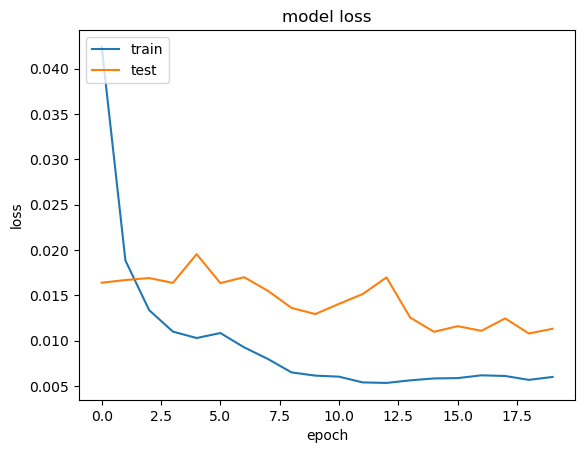

<Figure size 640x480 with 0 Axes>

In [7]:

create_plots(history)